# Music Market Decision Making Support Project

In this project, we are going to use Chinook data, which provides international sales of a music market. The table structure is given below:

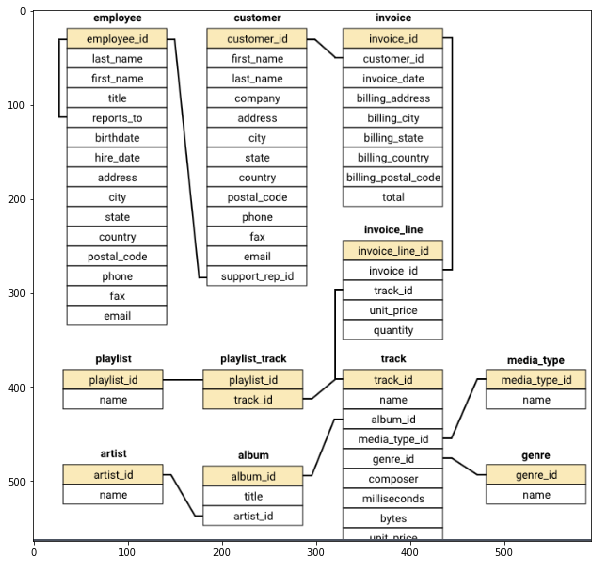

In [1]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
%matplotlib inline 
img = mpimg.imread('tables.PNG')  
plt.figure(figsize=(10,10))  
plt.imshow(img)

In [2]:
import sqlite3
import pandas as pd

In [3]:
def run_query(q):
    conn = sqlite3.connect("chinook.db")
    return pd.read_sql_query(q,conn)

In [4]:
def run_command(qq):
    conn = sqlite3.connect("chinook.db")
    return conn.execute(qq).fetchall()
    

In [5]:
def show_tables():
    query = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view')"
    return run_command(query)

In [6]:
show_tables()

[('album', 'table'),
 ('artist', 'table'),
 ('customer', 'table'),
 ('employee', 'table'),
 ('genre', 'table'),
 ('invoice', 'table'),
 ('invoice_line', 'table'),
 ('media_type', 'table'),
 ('playlist', 'table'),
 ('playlist_track', 'table'),
 ('track', 'table')]

In [7]:
q ="""
SELECT
    g.name genre, SUM(il.quantity) sales_num
FROM invoice_line il
INNER JOIN track t ON t.track_id = il.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
WHERE i.billing_country = 'USA'
GROUP BY 1
ORDER BY 2 DESC
"""

In [8]:
sales_by_genre = run_query(q)

In [9]:
sales_by_genre.columns

Index(['genre', 'sales_num'], dtype='object')

In [10]:
sales_by_genre["sales_num_perc"]=100* round(sales_by_genre["sales_num"]/sum(sales_by_genre["sales_num"]),3)

In [11]:
sales_by_genre.set_index("genre", inplace=True)

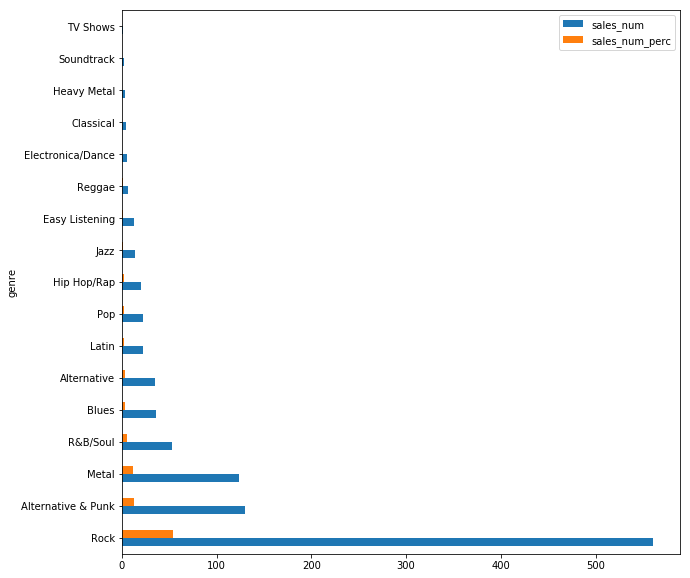

In [25]:
sales_by_genre.plot.barh(figsize=(10,10))

We had been asked to choose three of the following artists in order of popularity of their genres. 

Artist Name | Genre
----------- | -----
Regal   | Hip-hop
Red Tone| Punk
Meteor and the Girls | Pop
Slim Jim Bites | Blues


In order, the most popular music genres among the four candidates in USA are PUNK 2,BLUES 5, POP 8,HIP HOP 9.
Therefore we should advise our employer to put Red Tone, Slim Jim Bites and Meteor and the Girls on sale at the market.

On the other hand, these three genres are only 17% of the total market sales and only rock has 53% of the market itself.

## SALES AGENTS' PERFORMANCES
Now we are asked to put an evaluation forward for the sale agents performances.

In [13]:
q_temp = "SELECT * FROM employee LIMIT 10"
run_query(q_temp).title.unique()

array(['General Manager', 'Sales Manager', 'Sales Support Agent',
       'IT Manager', 'IT Staff'], dtype=object)

In [14]:
q_sales="""
SELECT 
    e.first_name || " " || e.last_name agent_name,
    SUM(i.total) total_purchases,
    e.hire_date

FROM employee e
INNER JOIN customer c ON e.employee_id = c.support_rep_id
INNER JOIN invoice i ON c.customer_id = i.customer_id
WHERE e.title = "Sales Support Agent" 
GROUP BY 1
ORDER BY 2 DESC

"""

In [15]:
sales = run_query(q_sales)
run_query(q_sales)

,agent_name,total_purchases,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


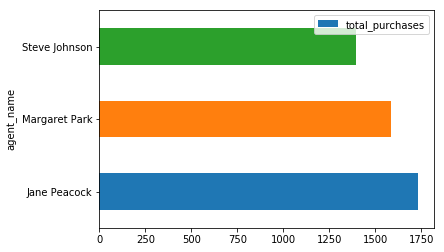

In [16]:
sales.plot.barh(x="agent_name", y="total_purchases")

Jane Peacock is the best salesperson and it is seen that, more experience yield to more sales amounts.

## SALES ON COUNTRY BASIS
Now we are asked to make an analysis about the sales on a country basis.

In [17]:
q_country = """
WITH sales_country AS (
    SELECT
        CASE WHEN ( 
                    SELECT 
                        COUNT(DISTINCT customer_id)
                        FROM customer
                        WHERE country = c.country
                    ) = 1 THEN "Other"
                    ELSE c.country
                    END AS country,
        i.*
        
        FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
    
)

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
    FROM (
        SELECT 
            country,
            COUNT(DISTINCT customer_id) customers,
            SUM(total) total_sales,
            SUM(total)/COUNT(DISTINCT customer_id)customer_lifetime_value, 
            SUM(total)/COUNT(DISTINCT invoice_id) average_order,
            CASE WHEN country = "Other" THEN 1 ELSE 0 END AS Sort
        
        FROM sales_country sc
           GROUP BY country
           ORDER BY Sort ASC, 3 DESC
           )
    
"""
sales_by_country = run_query(q_country)
run_query(q_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


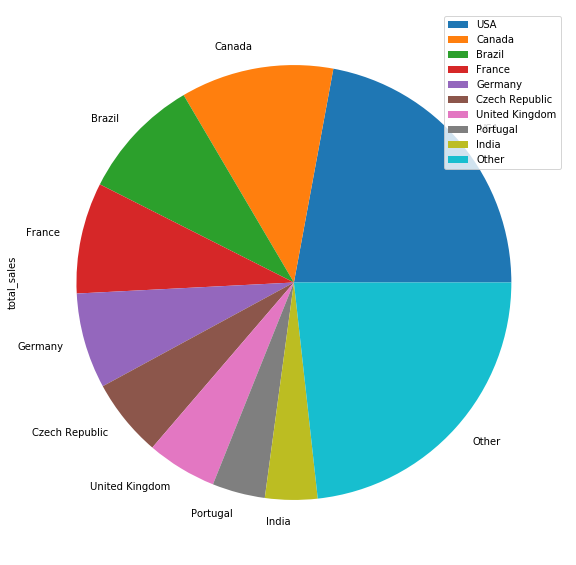

In [18]:
sales_by_country.set_index("country").plot.pie("total_sales", figsize=(10,10))

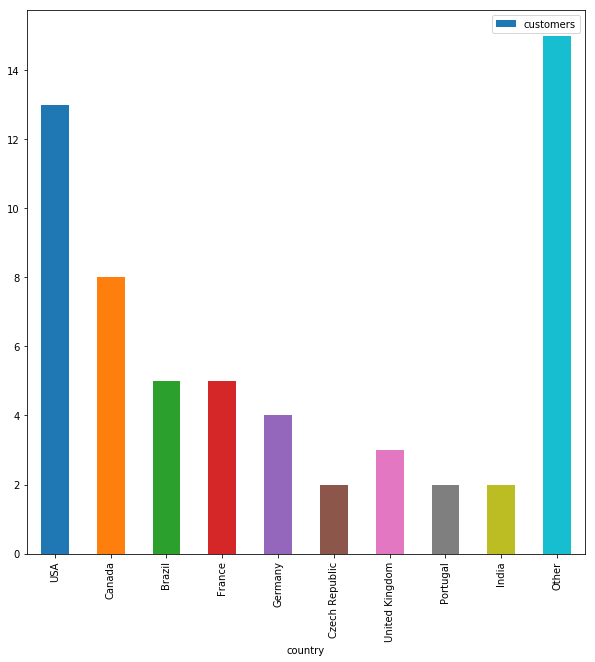

In [19]:
sales_by_country.plot.bar(x="country", y="customers", figsize=(10,10))

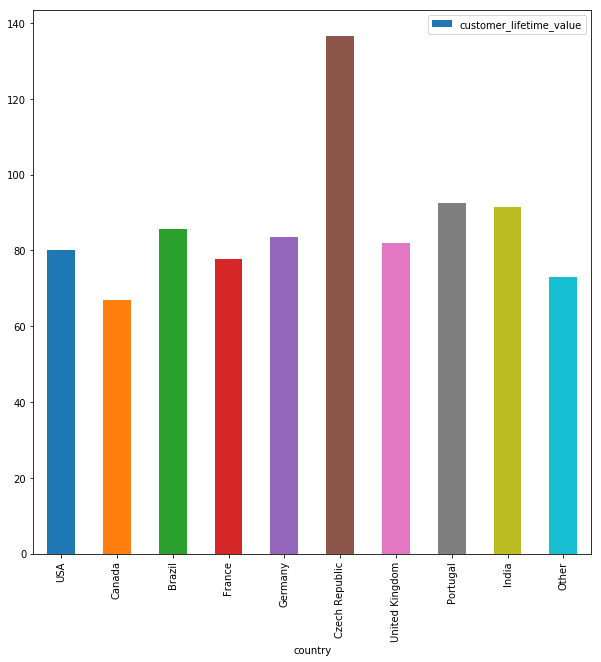

In [20]:
sales_by_country.plot.bar(x="country", y="customer_lifetime_value", figsize=(10,10))

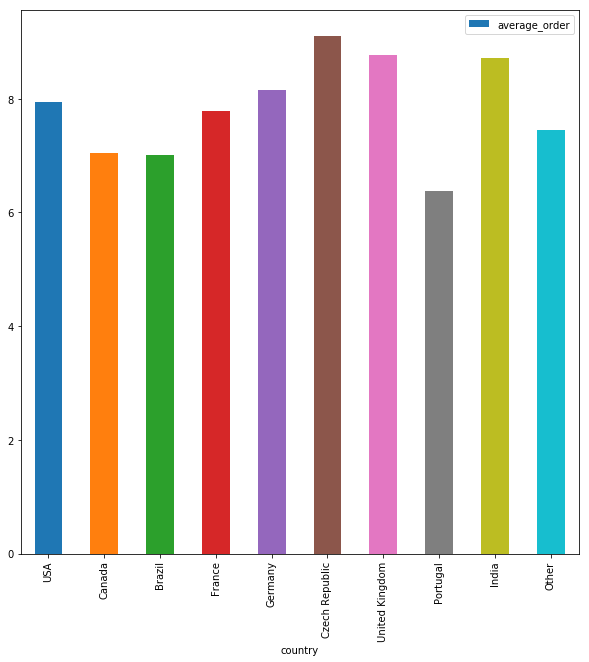

In [21]:
sales_by_country.plot.bar(x="country", y="average_order", figsize=(10,10))

Based on the data, there may be opportunity in the following countries:

    Czech Republic (Czechia)
    United Kingdom
    India

According to the data in hand, amount of sales from Czechia, UK and India are low, however customer lifetime value and average of the orders show that these countries have potential.

## ALBUM PURCHASE ANALYSIS
Now we are asked help about a marketing decision, which is "Is it a better idea to pay copyrights of only the popular songs or the whole albums?"
In order to find an answer for this, we are going to find out what percentage of the sales include whole albums.

In [22]:
q_album = """
WITH invoice_tot AS(
SELECT
    i.invoice_id,
    il.invoice_line_id,
    t.track_id,
    t.album_id
    
    FROM invoice i
    INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
),

album_track AS(

    SELECT
        t.track_id,
        t.album_id
        
    FROM track t
    WHERE (
            SELECT 
                COUNT(DISTINCT track_id)
            FROM track
            WHERE
                album_id = t.album_id
            ) > 2 
        
),

album_or_not AS(
    SELECT
        
        it.*,
        CASE WHEN (
            
            SELECT track_id
            FROM album_track
            WHERE album_id = it.album_id
            
            EXCEPT
            
            SELECT track_id 
            FROM invoice_tot
            WHERE invoice_id = it.invoice_id AND album_id=it.album_id
            
            ) IS NULL THEN "ALBUM" ELSE "NOT ALBUM" END AS album_not
    
    FROM invoice_tot it

)


        
SELECT
    COUNT (DISTINCT invoice_id) num_invoices,
    ROUND(CAST ((SELECT COUNT(DISTINCT invoice_id) 
        FROM album_or_not 
        WHERE album_not ='ALBUM')as float)
    /COUNT(DISTINCT invoice_id) *100,2) percentage
FROM album_or_not


"""



run_query(q_album)

,num_invoices,percentage
0,614,34.69


This table shows that 34.69% of the purchases includes a full album. Based on this figure, I would strongly recommend against purchasing only select tracks from albums from record companies.